<a href="https://colab.research.google.com/github/wakamezake/Notebooks/blob/master/Deeplearning_tutorial_for_cell_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<iframe src="//www.slideshare.net/slideshow/embed_code/key/wWQoShy9DDyj2y" width="595" height="485" frameborder="0" marginwidth="0" marginheight="0" scrolling="no" style="border:1px solid #CCC; border-width:1px; margin-bottom:5px; max-width: 100%;" allowfullscreen> </iframe> <div style="margin-bottom:5px"> <strong> <a href="//www.slideshare.net/DaisukeTakao/ss-234001580" title="チュートリアル：細胞画像を使った初めてのディープラーニング" target="_blank">チュートリアル：細胞画像を使った初めてのディープラーニング</a> </strong> from <strong><a href="https://www.slideshare.net/DaisukeTakao" target="_blank">DaisukeTakao</a></strong> </div>

In [ ]:
!wget https://zenodo.org/record/3825945/files/G2.zip
!wget https://zenodo.org/record/3825945/files/notG2.zip

--2020-10-04 12:30:02--  https://zenodo.org/record/3825945/files/G2.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5197482 (5.0M) [application/octet-stream]
Saving to: ‘G2.zip’

G2.zip              100%[===================>]   4.96M  5.24MB/s    in 0.9s    

2020-10-04 12:30:04 (5.24 MB/s) - ‘G2.zip’ saved [5197482/5197482]

--2020-10-04 12:30:04--  https://zenodo.org/record/3825945/files/notG2.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4799688 (4.6M) [application/octet-stream]
Saving to: ‘notG2.zip’

notG2.zip           100%[===================>]   4.58M  4.81MB/s    in 1.0s    

2020-10-04 12:30:06 (4.81 MB/s) - ‘notG2.zip’ saved [4799688/4799688]



In [ ]:
!unzip -qq G2.zip
!unzip -qq notG2.zip
!mkdir dataset
!mv G2/ dataset
!mv notG2 dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import copy
import time
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.autograd import Variable
import torch
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
dataset_root_path = './dataset'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transformers = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

set_keys = ['train', 'val']
batch_size = 32
image_dataset = datasets.ImageFolder(dataset_root_path, transform=transformers)
train_size = int(0.8 * len(image_dataset))
validation_size  = len(image_dataset) - train_size
data_train, data_validation = torch.utils.data.random_split(image_dataset,
                                                            [train_size, validation_size])

dataloaders = {x: torch.utils.data.DataLoader(d, batch_size=32,
                                             shuffle=True, num_workers=4)
              for x, d in zip(set_keys, [data_train, data_validation])}
dataset_sizes = {"train":train_size, "val":validation_size}
class_names = image_dataset.classes

In [ ]:
image_dataset.class_to_idx

{'G2': 0, 'notG2': 1}

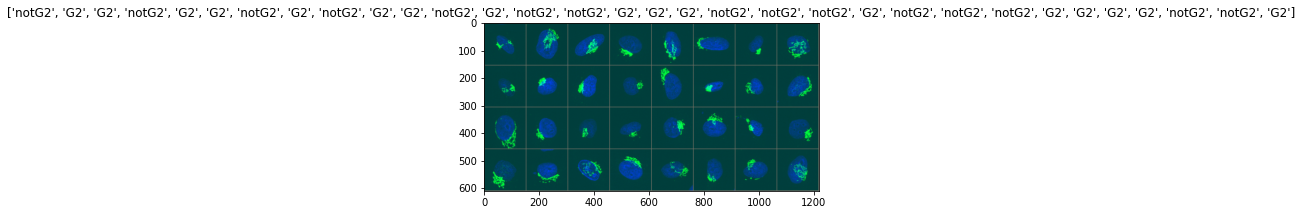

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2616 Acc: 0.8993
val Loss: 0.3756 Acc: 0.7917

Epoch 1/24
----------
train Loss: 0.1784 Acc: 0.9340
val Loss: 0.1701 Acc: 0.9444

Epoch 2/24
----------
train Loss: 0.0808 Acc: 0.9861
val Loss: 0.1883 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.0395 Acc: 1.0000
val Loss: 0.2031 Acc: 0.9028

Epoch 4/24
----------
train Loss: 0.0372 Acc: 1.0000
val Loss: 0.1628 Acc: 0.9444

Epoch 5/24
----------
train Loss: 0.0248 Acc: 1.0000
val Loss: 0.1535 Acc: 0.9444

Epoch 6/24
----------
train Loss: 0.0215 Acc: 1.0000
val Loss: 0.1490 Acc: 0.9444

Epoch 7/24
----------
train Loss: 0.0195 Acc: 1.0000
val Loss: 0.1477 Acc: 0.9444

Epoch 8/24
----------
train Loss: 0.0204 Acc: 1.0000
val Loss: 0.1459 Acc: 0.9444

Epoch 9/24
----------
train Loss: 0.0361 Acc: 1.0000
val Loss: 0.1442 Acc: 0.9444

Epoch 10/24
----------
train Loss: 0.0166 Acc: 1.0000
val Loss: 0.1442 Acc: 0.9444

Epoch 11/24
----------
train Loss: 0.0221 Acc: 1.0000
val Loss: 0.1447 Acc: 0.9444

Ep

In [ ]:
torch.__version__

'1.6.0+cu101'

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

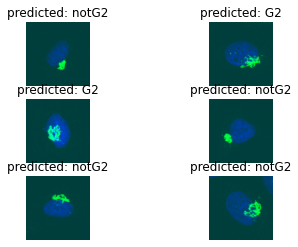

In [ ]:
visualize_model(model_ft)